In [33]:
import pandas as pd

In [34]:
df = pd.read_csv('~/Downloads/3stations-7k.csv')

In [35]:
df = df[['transit_timestamp', 'station_complex_id', 'borough', 'fare_class_category', 'ridership']]
df.head()

,transit_timestamp,station_complex_id,borough,fare_class_category,ridership
0,10/18/2024 04:00:00 PM,10,Manhattan,OMNY - Other,3
1,10/18/2024 11:00:00 PM,10,Manhattan,OMNY - Other,1
2,10/22/2024 02:00:00 PM,10,Manhattan,OMNY - Other,3
3,10/17/2024 11:00:00 AM,10,Manhattan,Metrocard - Fair Fare,9
4,10/17/2024 05:00:00 AM,10,Manhattan,Metrocard - Other,3


In [36]:
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df

/var/folders/sq/wp5xsw8j32nc80nbtg57p5p40000gn/T/ipykernel_39828/4040815382.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])


,transit_timestamp,station_complex_id,borough,fare_class_category,ridership
0,2024-10-18 16:00:00,10,Manhattan,OMNY - Other,3
1,2024-10-18 23:00:00,10,Manhattan,OMNY - Other,1
2,2024-10-22 14:00:00,10,Manhattan,OMNY - Other,3
3,2024-10-17 11:00:00,10,Manhattan,Metrocard - Fair Fare,9
4,2024-10-17 05:00:00,10,Manhattan,Metrocard - Other,3
...,...,...,...,...,...
724275,2020-07-05 11:00:00,109,Queens,Metrocard - Full Fare,32
724276,2020-07-05 19:00:00,109,Queens,Metrocard - Other,4
724277,2020-07-05 09:00:00,109,Queens,Metrocard - Unlimited 7-Day,6
724278,2020-07-05 09:00:00,109,Queens,Metrocard - Unlimited 30-Day,9


In [37]:
#df_10 = df[ df['station_complex_id'] == 10 ].sort_values(by='transit_timestamp')
df_10 = df

In [38]:
import datetime
from sklearn.preprocessing import OneHotEncoder

def prepare(df):
    df = df.copy()
    df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
    df['day_of_week'] = df['transit_timestamp'].dt.dayofweek
    df['hour_of_day'] = df['transit_timestamp'].dt.hour
    df = df.drop(['transit_timestamp'], axis=1)
    
    return df

In [39]:
df_10 = prepare(df_10)
df_10

,station_complex_id,borough,fare_class_category,ridership,day_of_week,hour_of_day
0,10,Manhattan,OMNY - Other,3,4,16
1,10,Manhattan,OMNY - Other,1,4,23
2,10,Manhattan,OMNY - Other,3,1,14
3,10,Manhattan,Metrocard - Fair Fare,9,3,11
4,10,Manhattan,Metrocard - Other,3,3,5
...,...,...,...,...,...,...
724275,109,Queens,Metrocard - Full Fare,32,6,11
724276,109,Queens,Metrocard - Other,4,6,19
724277,109,Queens,Metrocard - Unlimited 7-Day,6,6,9
724278,109,Queens,Metrocard - Unlimited 30-Day,9,6,9


In [40]:
def prepare2(df):
    ohe = OneHotEncoder(feature_name_combiner='concat')
    f = ohe.fit_transform(df[['station_complex_id','fare_class_category', 'borough']])
    X_ohe = pd.DataFrame(f.toarray(), columns=ohe.get_feature_names_out())
    
    df = df.drop(['fare_class_category', 'station_complex_id', 'borough'], axis=1)
    y = df['ridership']
    X = df.drop(['ridership'], axis=1)
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
    return pd.concat([X_scaled, X_ohe], axis=1), y

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X, y = prepare2(df_10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
len(X_train), len(X_test), len(y_train)

(579424, 144856, 579424)

In [ ]:
import warnings
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam


In [ ]:
from tensorflow.keras.layers import Activation

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1), 
    Activation('elu')
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

In [44]:
import matplotlib.pyplot as plt
def ground_predicted(mdl, desc=''):
    y_hat = mdl.predict(X_test)

    #fig, ax = plt.subplots()

    #plt.figure(figsize=(20, 20))
    
    plt.scatter(y_test, y_hat)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=1)
    
    #ax.set_xlabel('Actual (Ground Truth)')
    #ax.set_ylabel('Predicted')
    #ax.set_title(f"Ground Truth vs Predicted | {desc}")

In [45]:
from xgboost import XGBRegressor

In [46]:
model = XGBRegressor(n_estimators=1000, early_stopping_rounds=50, max_depth=7, learning_rate=0.01)

In [47]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[0]	validation_0-rmse:94.22700	validation_1-rmse:93.97758
[10]	validation_0-rmse:88.57360	validation_1-rmse:88.40395
[20]	validation_0-rmse:83.65291	validation_1-rmse:83.55472
[30]	validation_0-rmse:79.38069	validation_1-rmse:79.34684
[40]	validation_0-rmse:75.70073	validation_1-rmse:75.72289
[50]	validation_0-rmse:72.55073	validation_1-rmse:72.62345
[60]	validation_0-rmse:69.85933	validation_1-rmse:69.97586
[70]	validation_0-rmse:67.55418	validation_1-rmse:67.70928
[80]	validation_0-rmse:65.59538	validation_1-rmse:65.78498
[90]	validation_0-rmse:63.93112	validation_1-rmse:64.14908
[100]	validation_0-rmse:62.52270	validation_1-rmse:62.76347
[110]	validation_0-rmse:61.32885	validation_1-rmse:61.58822
[120]	validation_0-rmse:60.32457	validation_1-rmse:60.59921
[130]	validation_0-rmse:59.48162	validation_1-rmse:59.76952
[140]	validation_0-rmse:58.77576	validation_1-rmse:59.07541
[150]	validation_0-rmse:58.17749	validation_1-rmse:58.48695
[160]	validation_0-rmse:57.67873	validation_1-rmse:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_)

,0
day_of_week,0.010482
hour_of_day,0.040875
station_complex_id_10,0.148032
station_complex_id_103,0.006426
station_complex_id_109,0.000435
fare_class_category_Metrocard - Fair Fare,0.001041
fare_class_category_Metrocard - Full Fare,0.140993
fare_class_category_Metrocard - Other,0.001646
fare_class_category_Metrocard - Seniors & Disability,0.000595
fare_class_category_Metrocard - Students,0.002099


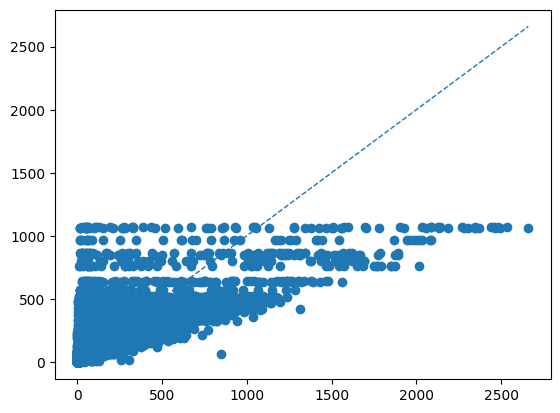

In [49]:
ground_predicted(model)

In [50]:
preds = model.predict(X_test)

In [51]:
from sklearn.metrics import r2_score

In [52]:
r2_score(y_test, preds)

0.6614012718200684

In [56]:
for idx in range(len(y_test)):
    if abs(y_test.iloc[idx] - preds[idx]) > 500:
        print(X_test.iloc[idx])

day_of_week                                             0.333333
hour_of_day                                             0.782609
station_complex_id_10                                   1.000000
station_complex_id_103                                  0.000000
station_complex_id_109                                  0.000000
fare_class_category_Metrocard - Fair Fare               0.000000
fare_class_category_Metrocard - Full Fare               0.000000
fare_class_category_Metrocard - Other                   0.000000
fare_class_category_Metrocard - Seniors & Disability    0.000000
fare_class_category_Metrocard - Students                0.000000
fare_class_category_Metrocard - Unlimited 30-Day        0.000000
fare_class_category_Metrocard - Unlimited 7-Day         0.000000
fare_class_category_OMNY - Fair Fare                    0.000000
fare_class_category_OMNY - Full Fare                    1.000000
fare_class_category_OMNY - Other                        0.000000
fare_class_category_OMNY 